## AI Deepfake Detection - EDA

## Imports

In [39]:
import pandas as pd
import json
import os
from IPython.display import Video

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os 
import ffmpeg

### Exploratory Data Analysis (EDA)

In [10]:
# Helper functions to load data/video
def load_metadata(metadata_path):
    """Load metadata from a JSON file and return a DataFrame."""
    with open(metadata_path) as f:
        metadata = json.load(f)
    df = pd.DataFrame.from_dict(metadata, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'video_filename'}, inplace=True)
    return df

def play_video(video_filename, video_folder='../data/train_sample_videos'):
    """Play a video given its filename."""
    video_path = os.path.join(video_folder, video_filename)
    if os.path.exists(video_path):
        return Video(video_path,width=320, height=320)
    else:
        print(f"Video file {video_filename} does not exist.")

In [14]:
## Load the training and test set
train_metadata_path = '../data/train_sample_videos/metadata.json'
train_metadata_df = load_metadata(train_metadata_path)
train_metadata_df

,video_filename,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4
...,...,...,...,...
395,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4
396,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4
397,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4
398,eudeqjhdfd.mp4,REAL,train,None


In [35]:
# Distribution of real vs fake
def plot_label_distribution(df):
    """Plot the percentage distribution of real and fake videos, showing both percentage and raw counts."""

    # Calculate the raw counts and percentages
    label_counts = df['label'].value_counts()
    label_percentages = df['label'].value_counts(normalize=True) * 100

    # Create a DataFrame to combine both counts and percentages
    label_df = pd.DataFrame({'Count': label_counts, 'Percentage': label_percentages})

    # Plot the counts
    plt.figure(figsize=(6, 6))
    ax = sns.barplot(hue=label_df.index, x=label_df.index, 
                     y=label_df['Count'], palette='coolwarm',
                     legend=False)

    # Add labels with both raw counts and percentages
    for i in ax.containers:
        ax.bar_label(i, labels=[f'{v.get_height():,.0f} ({v.get_height()/label_counts.sum()*100:.1f}%)' for v in i])

    # Set plot titles and labels
    plt.title('Distribution of Real vs Fake Videos')
    plt.xlabel('Video Label')
    plt.ylabel('Count')
    plt.show()

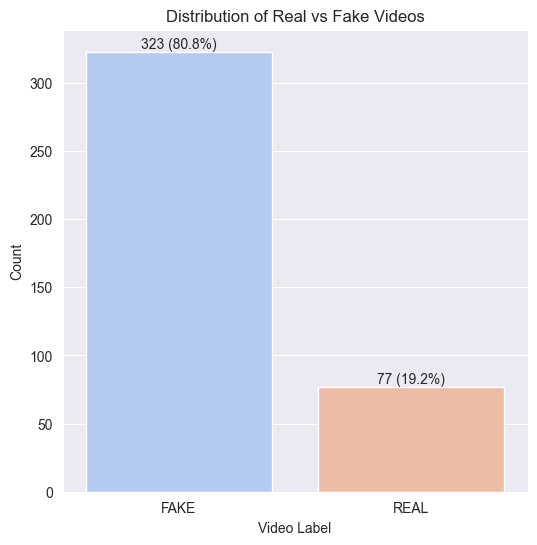

In [36]:
plot_label_distribution(train_metadata_df)

Currently, the metadata file is quite limited, only telling us the video name and the label of the video, which will help us in training our model. However, we also want to take a look at metadata about the videos themselves, so we will write some code to get this information out.

In [42]:
def get_video_metadata(video_path):
    """Extract metadata from a video using ffmpeg."""
    try:
        probe = ffmpeg.probe(video_path)
        video_info = next(stream for stream in probe['streams'] if stream['codec_type'] == 'video')

        # Extracting relevant metadata
        duration = float(probe['format']['duration'])  # Duration in seconds
        frame_rate = eval(video_info['r_frame_rate'])  # Frames per second
        width = int(video_info['width'])  # Video width
        height = int(video_info['height'])  # Video height
        codec = video_info['codec_name']  # Codec used to encode the video
        file_size = int(probe['format']['size'])  # File size in bytes

        return {
            'duration': duration,
            'frame_rate': frame_rate,
            'resolution': f"{width}x{height}",
            'codec': codec,
            'file_size': file_size
        }
    except Exception as e:
        print(f"Error retrieving metadata for {video_path}: {e}")
        return None

def get_all_videos_metadata(df, video_dir):
    """Extract metadata for all videos in the DataFrame and add it as new columns."""
    metadata_list = []

    for video_name in df['video_filename']:
        video_path = os.path.join(video_dir, video_name)
        metadata = get_video_metadata(video_path)
        if metadata:
            metadata_list.append(metadata)
        else:
            metadata_list.append({'duration': None, 'frame_rate': None, 'resolution': None, 'codec': None, 'file_size': None})

    # Add the extracted metadata to the DataFrame
    metadata_df = pd.DataFrame(metadata_list)
    df = pd.concat([df.reset_index(drop=True), metadata_df.reset_index(drop=True)], axis=1)

    return df

In [43]:
train_video_path = '../data/train_sample_videos'
train_metadata_df = get_all_videos_metadata(train_metadata_df, train_video_path)
train_metadata_df

,video_filename,label,split,original,duration,frame_rate,resolution,codec,file_size
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,10.022,29.970,1920x1080,h264,10922046
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,10.022,29.970,1920x1080,h264,4472228
2,abarnvbtwb.mp4,REAL,train,None,10.022,29.970,1920x1080,h264,5032214
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,10.022,29.970,1920x1080,h264,2796925
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,10.022,29.970,1920x1080,h264,3513304
...,...,...,...,...,...,...,...,...,...
395,etejaapnxh.mp4,FAKE,train,wtreibcmgm.mp4,10.022,29.970,1920x1080,h264,5265699
396,etmcruaihe.mp4,FAKE,train,afoovlsmtx.mp4,10.024,29.969,1080x1920,h264,3441035
397,etohcvnzbj.mp4,FAKE,train,bdnaqemxmr.mp4,10.022,29.970,1920x1080,h264,8627946
398,eudeqjhdfd.mp4,REAL,train,None,10.022,29.970,1920x1080,h264,7169947


In [55]:
def plot_codec_distribution(df, ax):
    """Plot the distribution of video codecs."""
    sns.countplot(hue = 'codec', x='codec', data=df, palette='Set2', ax=ax, legend=False)
    ax.set_title('Distribution of Video Codecs')
    ax.set_xlabel('Video Codec')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

def plot_frame_rate_distribution(df, ax):
    """Plot the distribution of video frame rates."""
    sns.histplot(df['frame_rate'], kde=True, bins=20, color='purple', ax=ax)
    ax.set_title('Distribution of Frame Rates')
    ax.set_xlabel('Frame Rate (FPS)')
    ax.set_ylabel('Frequency')

def plot_resolution_distribution(df, ax):
    """Plot the distribution of video resolutions."""
    sns.countplot(hue = 'resolution', y='resolution', data=df, palette='coolwarm', ax=ax, order=df['resolution'].value_counts().index, legend=False)
    ax.set_title('Distribution of Video Resolutions')
    ax.set_xlabel('Count')
    ax.set_ylabel('Resolution')

def plot_file_size_distribution(df, ax):
    """Plot the distribution of video file sizes."""
    sns.histplot(df['file_size'] / (1024 * 1024), kde=True, bins=20, color='green', ax=ax)  # Convert file size from bytes to MB
    ax.set_title('Distribution of Video File Sizes')
    ax.set_xlabel('File Size (MB)')
    ax.set_ylabel('Frequency')

def plot_combined_video_metadata(df):
    """Plot video metadata distributions in subplots using existing functions."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Video Metadata Distributions', fontsize=16)

    # 1. Video Codec Distribution
    plot_codec_distribution(df, axes[0, 0])

    # 2. Frame Rate Distribution
    plot_frame_rate_distribution(df, axes[0, 1])

    # 3. Resolution Distribution
    plot_resolution_distribution(df, axes[1, 0])

    # 4. File Size Distribution
    plot_file_size_distribution(df, axes[1, 1])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for the title
    plt.show()

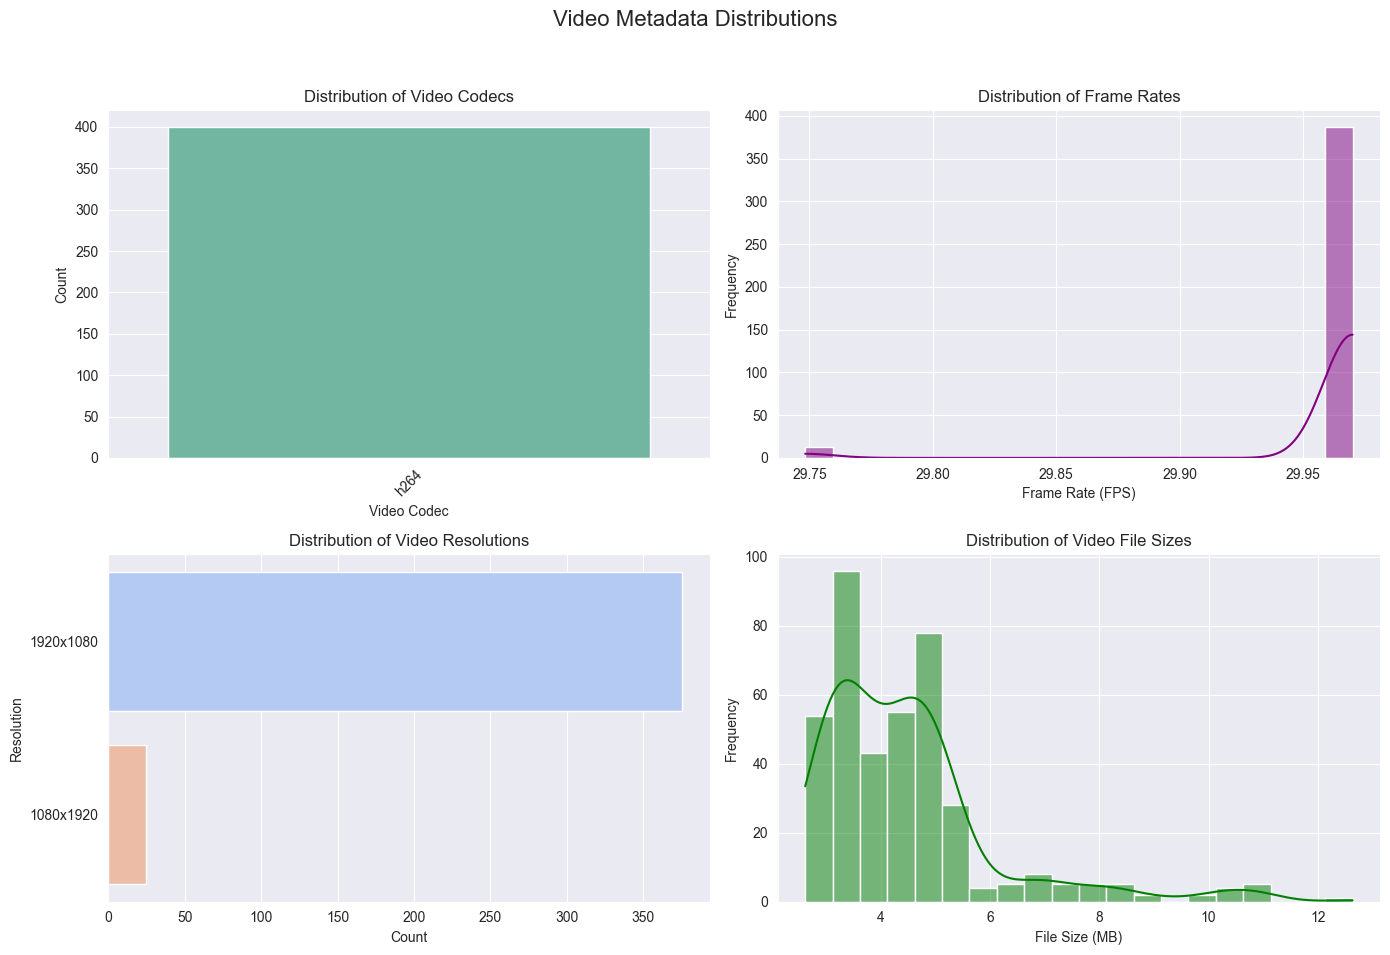

In [56]:
plot_combined_video_metadata(train_metadata_df)